<a href="https://colab.research.google.com/github/dcampoy1974/TFG/blob/main/velas_japonesas_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación y predicción de patrones de velas japonesas en índices bursátiles utilizando redes neuronales


Autor: David Campoy Miñarro

*   Fecha: 09/06/2024
*   Desarrollar un sistema de aprendizaje automático que sea capaz de identificar patrones de velas japonesas.

Identificar patrones de una sola vela japonesa.



# Paso 1: Carga librería talib
Librería TA-Lib para identificar y analizar patrones de velas japonesas en datos históricos de índices bursátiles.
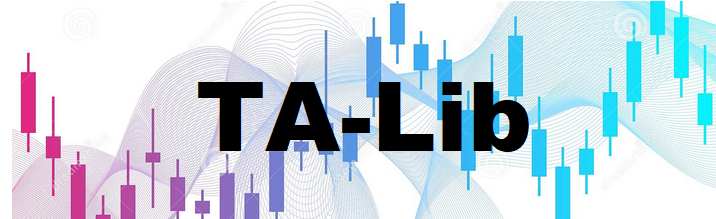

https://ta-lib.org/

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4091    0  4091    0     0   6733      0 --:--:-- --:--:-- --:--:--  6728
100  517k  100  517k    0     0   216k      0  0:00:02  0:00:02 --:--:--  566k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4135    0  4135    0     0   4261      0 --:--:-- --:--:-- --:--:--  4258
100  392k  100  392k    0     0   133k      0  0:00:02  0:00:02 --:--:--  337k


# Paso 2: Carga librería mplfinance
Librería mplfinance para generar y visualizar gráficos de velas japonesas de los patrones identificados en los datos históricos de índices bursátiles.

https://github.com/matplotlib/mplfinance


In [ ]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00


# Paso 3: Creación del dataset
El objetivo del código es cargar datos de un conjunto de archivos CSV, preprocesarlos, identificar patrones de velas en los datos financieros, generar un conjunto de datos binarios y graficar los patrones encontrados.

El programa comienza importando las bibliotecas necesarias, como pandas, numpy, talib, matplotlib.pyplot y os. Luego, define los nombres de las columnas esperadas en los archivos CSV mediante la lista column_names.

La función **cargar_datos(filepath)** carga datos desde un archivo CSV especificado por *filepath*, gestionando errores al cargar datos y devolviendo None si hay problemas. A continuación, la función **preprocesar_datos(data)** preprocesa los datos cargados, convirtiendo la columna de fechas a un formato de fecha correcto, convirtiendo las columnas de precios (Cierre, Apertura, Máximo, Mínimo) a tipo float, renombrando columnas de precios y eliminando la columna de volumen.

Para cada fila de datos, la función **calcular_distancias(open_price, high_price, low_price, close_price)** calcula varias métricas de las velas, como rangos, sombras y longitudes del cuerpo. La función **crear_dataset_binario(data, days_to_check=20)** identifica patrones de velas individuales utilizando la biblioteca talib, calcula indicadores técnicos como SMA, RSI y Williams %R, y genera un conjunto de datos binario con características calculadas y etiquetas de patrones.

La función **mostrar_patrones_encontrados(patterns)** cuenta y muestra el número de cada tipo de patrón encontrado en los datos, mientras que la función **graficar_patrones(pattern_counts)** grafica una barra con la cantidad de cada tipo de patrón encontrado.

Finalmente, la función **main()** define el directorio de los datos, carga, preprocesa y procesa los datos de cada archivo en el directorio, acumula los datos procesados en listas y los convierte en numpy arrays, muestra el número de muestras con y sin patrones, cuenta y muestra el número de patrones diferentes encontrados, guarda los datos procesados en un archivo NPZ y CSV, y llama a la función para graficar los patrones encontrados. La función main() se ejecuta cuando el script es ejecutado directamente.







Número de muestras con patrones: 14667
Número de muestras sin patrones: 39516

Número de patrones de una vela encontrados:
Doji: 4606
Dragonfly Doji: 1011
Gravestone Doji: 504
Hammer: 911
Hanging Man: 1432
Long Legged Doji: 1701
Marubozu: 4502
No Pattern: 39516
Número de patrones diferentes encontrados: 8


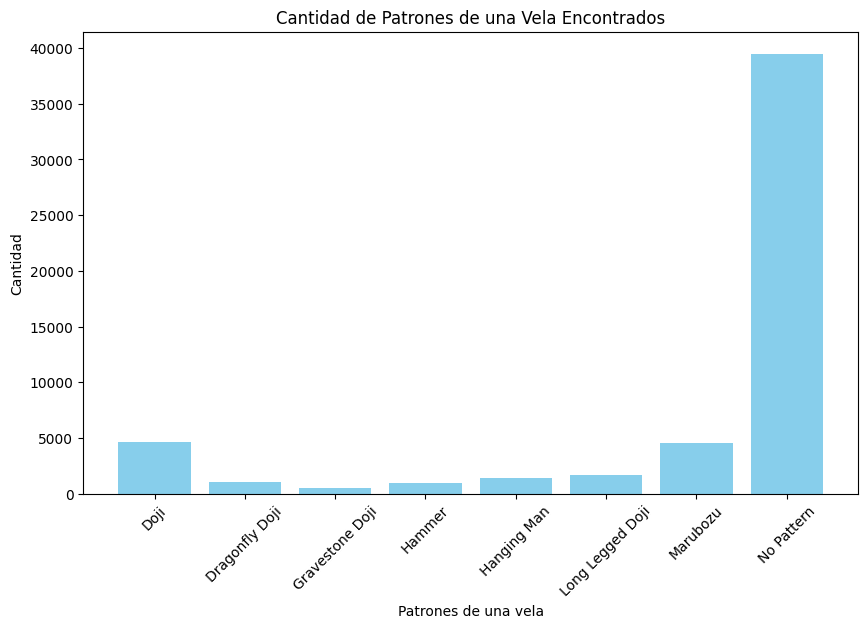

In [ ]:
# Paso 3: Cödigo para crear el dataset para el entranamiento de las redes neuronales.
# En primer lugar, utilizará la librería Ta-Lib para detectar los patrones de una única vela japonesa.
# En segundo lugar, se realizará un análisis de los patrones ya que Ta-Lib tiene problemas para diferenciar los Dojis.

import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import os

# Especificar los nombres de las columnas
column_names = ['Fecha', 'Cierre', 'Apertura', 'Máximo', 'Mínimo', 'Volumen', 'Cambio']

def cargar_datos(filepath):
    try:
        # Cargar los datos
        data = pd.read_csv(filepath, delimiter=',', quotechar='"', names=column_names, header=None, thousands='.', decimal=',', skiprows=1, on_bad_lines='skip')
        return data
    except Exception as e:
        print(f"Error al cargar los datos de {filepath}: {e}")
        return None

def preprocesar_datos(data):
    # Preprocesamiento de datos
    data['Fecha'] = data['Fecha'].astype(str).str.replace(r'\D', '', regex=True)
    data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d%m%Y', errors='coerce', dayfirst=True)
    data = data.dropna(subset=['Fecha']).sort_values(by='Fecha').reset_index(drop=True)
    for col in ['Cierre', 'Apertura', 'Máximo', 'Mínimo']:
        data[col] = data[col].astype(str).str.replace(',', '').astype(np.float64)
    data['Index'] = data.index
    data.rename(columns={'Apertura': 'Open', 'Máximo': 'High', 'Mínimo': 'Low', 'Cierre': 'Close'}, inplace=True)
    data.drop(columns=['Volumen'], inplace=True)
    return data

def calcular_distancias(open_price, high_price, low_price, close_price):
    total_range = high_price - low_price
    upper_shadow = high_price - max(open_price, close_price)
    lower_shadow = min(open_price, close_price) - low_price
    body_length = abs(open_price - close_price)
    return [
        round(high_price - open_price, 2),  # High - Open
        round(low_price - open_price, 2),   # Low - Open
        round(close_price - open_price, 2), # Close - Open
        round(open_price - close_price, 2), # Open - Close
        round(total_range, 2),              # Range
        round(body_length, 2),              # Body length
        round(upper_shadow, 2),             # Upper shadow
        round(lower_shadow, 2)              # Lower shadow
    ]

def crear_dataset_binario(data, days_to_check=20):
    X, y, colors, patterns, trends, smas, closes, rsis, willrs, future_trends = [], [], [], [], [], [], [], [], [], []
    single_candle_patterns = {
        'Doji': talib.CDLDOJI,
        'Hammer': talib.CDLHAMMER,
        'Hanging Man': talib.CDLHANGINGMAN,
        'Long Legged Doji': talib.CDLLONGLEGGEDDOJI,
        'Dragonfly Doji': talib.CDLDRAGONFLYDOJI,
        'Gravestone Doji': talib.CDLGRAVESTONEDOJI,
        'Marubozu': talib.CDLMARUBOZU
    }
    open_prices = data['Open'].values
    high_prices = data['High'].values
    low_prices = data['Low'].values
    close_prices = data['Close'].values

    # Calcular el promedio móvil simple (SMA) de 20 periodos, RSI de 14 periodos, y Williams %R de 14 periodos
    sma = talib.SMA(close_prices, timeperiod=20)
    rsi = talib.RSI(close_prices, timeperiod=14)
    willr = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=14)

    for i in range(len(close_prices)):
        detected_patterns = []
        for pattern_name, pattern_func in single_candle_patterns.items():
            pattern_result = pattern_func(open_prices, high_prices, low_prices, close_prices)
            if pattern_result[i] != 0:
                detected_patterns.append(pattern_name)

        actual_pattern = None
        if 'Doji' in detected_patterns:
            distance = calcular_distancias(open_prices[i], high_prices[i], low_prices[i], close_prices[i])
            total_range = distance[4]
            body_length = distance[5]
            upper_shadow = distance[6]
            lower_shadow = distance[7]

            if body_length <= 0.1 * total_range:  # Cuerpo pequeño
                if lower_shadow >= 0.9 * total_range and upper_shadow <= 0.1 * total_range:
                    actual_pattern = 'Dragonfly Doji'
                elif upper_shadow >= 0.9 * total_range and lower_shadow <= 0.1 * total_range:
                    actual_pattern = 'Gravestone Doji'
                elif abs(upper_shadow - lower_shadow) / total_range <= 0.2:
                    actual_pattern = 'Long Legged Doji'
                else:
                    actual_pattern = 'Doji'  # Clasificar como Doji genérico si no cumple las condiciones anteriores

            if actual_pattern:
                trend = 'Bullish' if close_prices[i] > sma[i] else 'Bearish'
                X.append(distance)
                y.append(1)
                color = 'Green' if close_prices[i] > open_prices[i] else 'Red'
                colors.append(color)
                patterns.append(actual_pattern)
                trends.append(trend)
                smas.append(sma[i])
                closes.append(close_prices[i])
                rsis.append(rsi[i])
                willrs.append(willr[i])

                # Calcular la tendencia futura basada en la media de los próximos days_to_check días
                if i + days_to_check < len(close_prices):
                    future_avg = np.mean(close_prices[i + 1:i + 1 + days_to_check])
                    future_trend = 1 if future_avg > close_prices[i] else 0
                    future_trends.append(future_trend)
                else:
                    future_trends.append(np.nan)

        elif len(detected_patterns) == 1:
            pattern_name = detected_patterns[0]
            distance = calcular_distancias(open_prices[i], high_prices[i], low_prices[i], close_prices[i])
            trend = 'Bullish' if close_prices[i] > sma[i] else 'Bearish'
            actual_pattern = pattern_name

            if pattern_name == 'Hammer' and trend != 'Bearish':
                actual_pattern = 'Hanging Man'
            elif pattern_name == 'Hanging Man' and trend != 'Bullish':
                actual_pattern = 'Hammer'

            if actual_pattern:
                X.append(distance)
                y.append(1)
                color = 'Green' if close_prices[i] > open_prices[i] else 'Red'
                colors.append(color)
                patterns.append(actual_pattern)
                trends.append(trend)
                smas.append(sma[i])
                closes.append(close_prices[i])
                rsis.append(rsi[i])
                willrs.append(willr[i])

                # Calcular la tendencia futura
                if i + days_to_check < len(close_prices):
                    future_trend = 1 if close_prices[i + days_to_check] > close_prices[i] else 0
                    future_trends.append(future_trend)
                else:
                    future_trends.append(np.nan)

        else:
            distance = calcular_distancias(open_prices[i], high_prices[i], low_prices[i], close_prices[i])
            trend = 'Bullish' if close_prices[i] > sma[i] else 'Bearish'

            X.append(distance)
            y.append(0)
            color = 'Green' if close_prices[i] > open_prices[i] else 'Red'
            colors.append(color)
            patterns.append('No Pattern')
            trends.append(trend)
            smas.append(sma[i])
            closes.append(close_prices[i])
            rsis.append(rsi[i])
            willrs.append(willr[i])
            future_trends.append(np.nan)  # No se calcula la tendencia futura para los patrones 'No Pattern'

    assert len(X) == len(y) == len(colors) == len(patterns) == len(trends) == len(smas) == len(closes) == len(rsis) == len(willrs) == len(future_trends), "Las listas no tienen la misma longitud"

    return np.array(X), np.array(y), np.array(colors), np.array(patterns), np.array(trends), np.array(smas), np.array(closes), np.array(rsis), np.array(willrs), np.array(future_trends)

def mostrar_patrones_encontrados(patterns):
    unique_patterns, counts = np.unique(patterns, return_counts=True)
    pattern_counts = dict(zip(unique_patterns, counts))
    print("\nNúmero de patrones de una vela encontrados:")
    for pattern, count in pattern_counts.items():
        print(f"{pattern}: {count}")
    return pattern_counts

def graficar_patrones(pattern_counts):
    patterns = list(pattern_counts.keys())
    counts = list(pattern_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(patterns, counts, color='skyblue')
    plt.xlabel('Patrones de una vela')
    plt.ylabel('Cantidad')
    plt.title('Cantidad de Patrones de una Vela Encontrados')
    plt.xticks(rotation=45)
    plt.show()


def main():
    dataset_dir = 'dataset'
    all_X, all_y, all_colors, all_patterns, all_trends, all_smas, all_closes, all_rsis, all_willr, all_future_trends = [], [], [], [], [], [], [], [], [], []

    for filename in os.listdir(dataset_dir):
        filepath = os.path.join(dataset_dir, filename)
        data = cargar_datos(filepath)
        if data is not None:
            data = preprocesar_datos(data)

            # Asegúrate de recibir los nueve valores devueltos por la función
            X, y, colors, patterns, trends, smas, closes, rsis, willr, future_trends = crear_dataset_binario(data)
            all_X.extend(X)
            all_y.extend(y)
            all_colors.extend(colors)
            all_patterns.extend(patterns)
            all_trends.extend(trends)
            all_smas.extend(smas)
            all_closes.extend(closes)
            all_rsis.extend(rsis)
            all_willr.extend(willr)
            all_future_trends.extend(future_trends)

    # Convertir a numpy arrays
    all_X = np.array(all_X)
    all_y = np.array(all_y)
    all_colors = np.array(all_colors)
    all_patterns = np.array(all_patterns)
    all_trends = np.array(all_trends)
    all_smas = np.array(all_smas)
    all_closes = np.array(all_closes)
    all_rsis = np.array(all_rsis)
    all_willr = np.array(all_willr)
    all_future_trends = np.array(all_future_trends)

    # Mostrar el número de muestras con y sin patrones
    num_patron = sum(all_y)
    num_no_patron = len(all_y) - num_patron
    print(f'Número de muestras con patrones: {num_patron}')
    print(f'Número de muestras sin patrones: {num_no_patron}')

    # Contar el número de patrones diferentes encontrados
    pattern_counts = mostrar_patrones_encontrados(all_patterns)
    print(f'Número de patrones diferentes encontrados: {len(pattern_counts)}')

    np.savez('binary_candle_dataset.npz', X=all_X, y=all_y)
    # Crear un DataFrame con los datos de las distancias y adicionales
    dataset = pd.DataFrame(all_X, columns=['High-Open', 'Low-Open', 'Close-Open', 'Open-Close', 'Range', 'Body Length', 'Upper Shadow', 'Lower Shadow'])
    dataset['Pattern'] = all_y
    dataset['Color'] = all_colors
    dataset['Pattern Type'] = all_patterns
    dataset['Trend'] = all_trends
    dataset['SMA_20'] = all_smas
    dataset['Close'] = all_closes
    dataset['RSI'] = all_rsis
    dataset['WillR'] = all_willr
    dataset['Future Trend'] = all_future_trends  # Añadir la columna de tendencia futura

    # Guardar el nuevo dataset en un fichero CSV
    dataset.to_csv('binary_candle_dataset.csv', index=False)

    # Graficar patrones encontrados
    graficar_patrones(pattern_counts)

if __name__ == "__main__":
    main()

# Paso 4: Distribución de clases
El objetivo del código es cargar un conjunto de datos desde un archivo CSV, contar las frecuencias de las clases en la columna 'Pattern', imprimir estas frecuencias para su revisión y crear un gráfico de barras para visualizar la distribución de las clases en el dataset.


Pattern
0    39516
1    14667
Name: count, dtype: int64


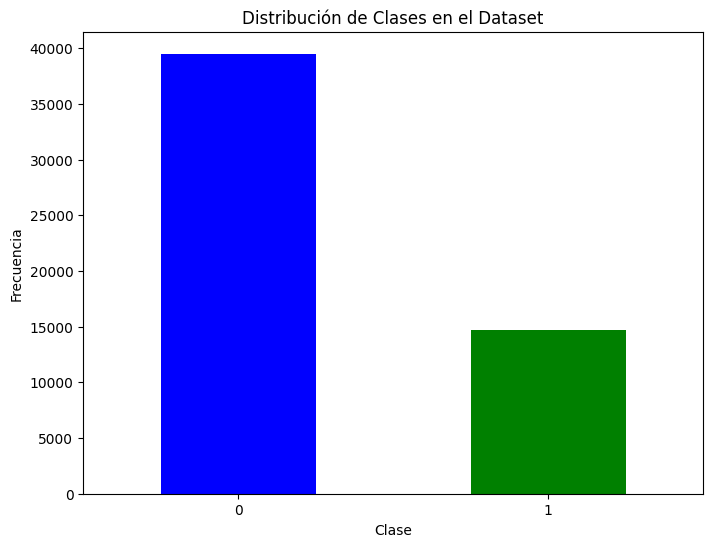

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('binary_candle_dataset.csv')

# Contar las frecuencias de las clases
class_counts = data['Pattern'].value_counts()

# Imprimir las cuentas para revisión
print(class_counts)

# Crear el gráfico de barras para mostrar la distribución de las clases
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribución de Clases en el Dataset')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)  # Mantener los nombres de las clases horizontales
plt.show()

# Paso 5: Clasificación binaria (patrón o no patrón)
El objetivo de esta red neuronal será aprender mediante el dataset las características de los patrones.

La red neuronal será capaz de decir si una vela japonesa es un patrón o no.


Epoch 1/500
734/734 [==============================] - 4s 4ms/step - loss: 0.6003 - accuracy: 0.6861 - val_loss: 0.5141 - val_accuracy: 0.7465
Epoch 2/500
734/734 [==============================] - 3s 4ms/step - loss: 0.4918 - accuracy: 0.7782 - val_loss: 0.4452 - val_accuracy: 0.8256
Epoch 3/500
734/734 [==============================] - 2s 2ms/step - loss: 0.4405 - accuracy: 0.8151 - val_loss: 0.4077 - val_accuracy: 0.8079
Epoch 4/500
734/734 [==============================] - 2s 2ms/step - loss: 0.4144 - accuracy: 0.8275 - val_loss: 0.3768 - val_accuracy: 0.8669
Epoch 5/500
734/734 [==============================] - 2s 2ms/step - loss: 0.3921 - accuracy: 0.8423 - val_loss: 0.3582 - val_accuracy: 0.8572
Epoch 6/500
734/734 [==============================] - 2s 3ms/step - loss: 0.3762 - accuracy: 0.8510 - val_loss: 0.3484 - val_accuracy: 0.8677
Epoch 7/500
734/734 [==============================] - 2s 2ms/step - loss: 0.3660 - accuracy: 0.8546 - val_loss: 0.3330 - val_accuracy: 0.8713

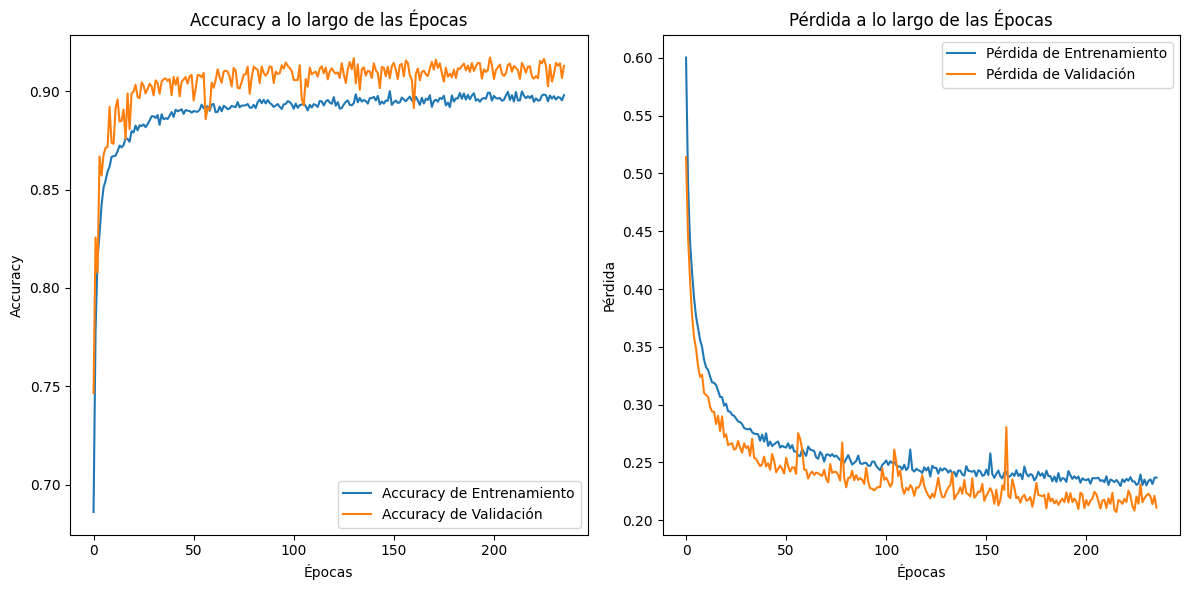

184/184 - 0s - loss: 0.2070 - accuracy: 0.9122 - 270ms/epoch - 1ms/step
Accuracy en el conjunto de prueba: 0.9122
184/184 [==============================] - 0s 2ms/step


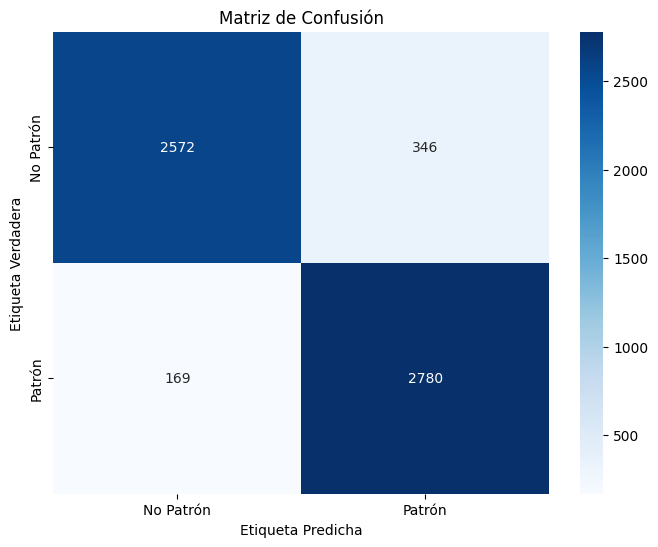

F1-score: 0.9152


In [ ]:
# Entrena la red neuronal para clasificación binaria (Patrón o no patrón)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
data = pd.read_csv('binary_candle_dataset.csv')

# Contar las frecuencias de las clases
class_counts = data['Pattern'].value_counts()
min_class_count = class_counts.min()

# Realizar submuestreo para equilibrar las clases
balanced_data = pd.DataFrame()
for label in class_counts.index:
    label_data = data[data['Pattern'] == label]
    resampled_data = resample(label_data,
                              replace=False,  # No reemplazar
                              n_samples=min_class_count,  # Igual al de la clase minoritaria
                              random_state=42)  # Para reproducibilidad
    balanced_data = pd.concat([balanced_data, resampled_data])

# Separar las características y las etiquetas
#X = balanced_data[['High-Open', 'Low-Open', 'Close-Open', 'Open-Close','Range','Body Length','Upper Shadow','Lower Shadow']].values
X = balanced_data[['Range','Body Length','Upper Shadow','Lower Shadow']].values
y = balanced_data['Pattern'].values

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadir una dimensión extra para cumplir con la entrada de la CNN
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definir el modelo de red neuronal convolucional
'''
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
'''

# Definir el modelo de red neuronal convolucional simplificado
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Configurar la parada temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Visualizar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy en el conjunto de prueba: {test_acc:.4f}')

# Predecir las etiquetas del conjunto de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calcular la matriz de confusión y F1-score
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Patrón', 'Patrón'], yticklabels=['No Patrón', 'Patrón'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Imprimir F1-score
print(f'F1-score: {f1:.4f}')

Epoch 1/500
734/734 [==============================] - 5s 5ms/step - loss: 1.2043 - accuracy: 0.6258 - val_loss: 0.8765 - val_accuracy: 0.6883
Epoch 2/500
734/734 [==============================] - 3s 4ms/step - loss: 0.7415 - accuracy: 0.6978 - val_loss: 0.6469 - val_accuracy: 0.7213
Epoch 3/500
734/734 [==============================] - 3s 4ms/step - loss: 0.6000 - accuracy: 0.7466 - val_loss: 0.5631 - val_accuracy: 0.7595
Epoch 4/500
734/734 [==============================] - 3s 4ms/step - loss: 0.5431 - accuracy: 0.7806 - val_loss: 0.5260 - val_accuracy: 0.7786
Epoch 5/500
734/734 [==============================] - 4s 6ms/step - loss: 0.5100 - accuracy: 0.8037 - val_loss: 0.4983 - val_accuracy: 0.8103
Epoch 6/500
734/734 [==============================] - 3s 4ms/step - loss: 0.4844 - accuracy: 0.8157 - val_loss: 0.4771 - val_accuracy: 0.8318
Epoch 7/500
734/734 [==============================] - 3s 4ms/step - loss: 0.4662 - accuracy: 0.8282 - val_loss: 0.4629 - val_accuracy: 0.8231

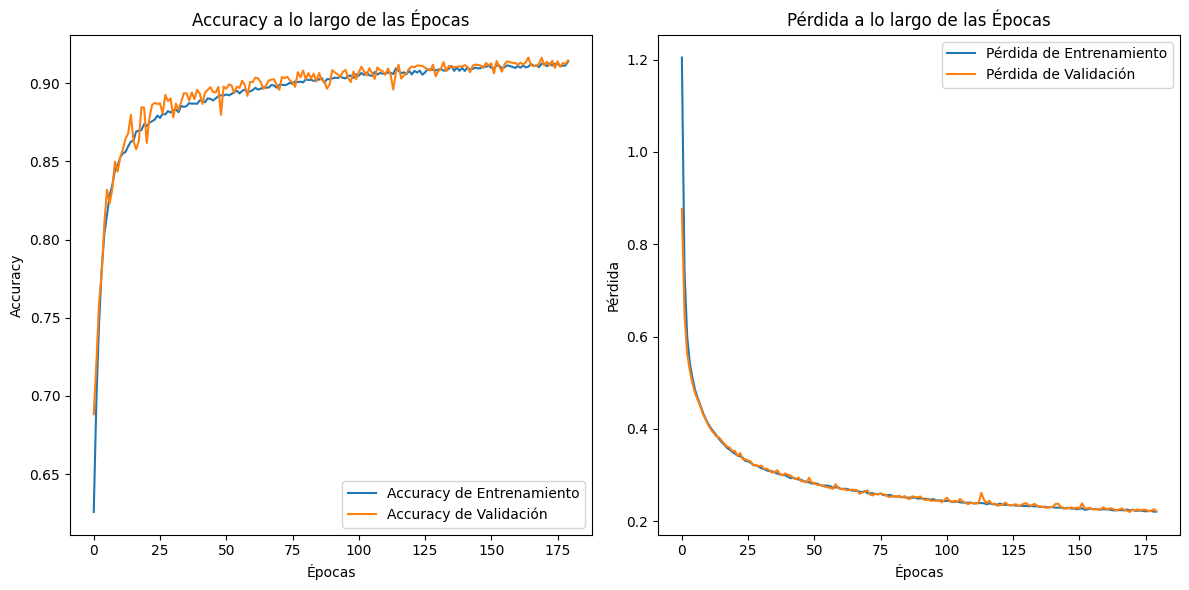

184/184 - 0s - loss: 0.2200 - accuracy: 0.9161 - 366ms/epoch - 2ms/step
Accuracy en el conjunto de prueba: 0.9161
184/184 [==============================] - 0s 2ms/step


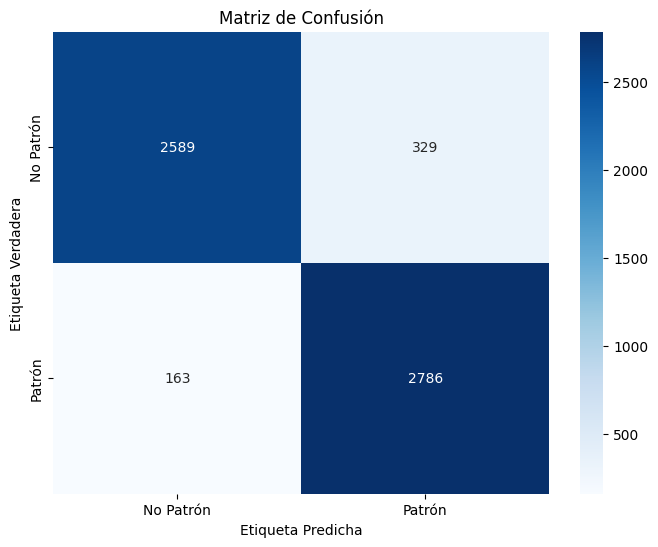

F1-score: 0.9189
Precision: 0.8944
Recall: 0.9447

Classification Report:
               precision    recall  f1-score   support

   No Patrón       0.94      0.89      0.91      2918
      Patrón       0.89      0.94      0.92      2949

    accuracy                           0.92      5867
   macro avg       0.92      0.92      0.92      5867
weighted avg       0.92      0.92      0.92      5867



In [ ]:
# Versión optimizada
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
data = pd.read_csv('binary_candle_dataset.csv')

# Contar las frecuencias de las clases
class_counts = data['Pattern'].value_counts()
min_class_count = class_counts.min()

# Realizar submuestreo para equilibrar las clases
balanced_data = pd.DataFrame()
for label in class_counts.index:
    label_data = data[data['Pattern'] == label]
    resampled_data = resample(label_data,
                              replace=False,  # No reemplazar
                              n_samples=min_class_count,  # Igual al de la clase minoritaria
                              random_state=42)  # Para reproducibilidad
    balanced_data = pd.concat([balanced_data, resampled_data])

# Separar las características y las etiquetas
X = balanced_data[['Range', 'Body Length', 'Upper Shadow', 'Lower Shadow']].values
y = balanced_data['Pattern'].values

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadir una dimensión extra para cumplir con la entrada de la CNN
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definir el modelo de red neuronal convolucional mejorado
input_shape = (X_train.shape[1], 1)  # Ajusta este valor según la forma real de tus datos

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con un optimizador diferente
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Configurar la parada temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Visualizar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy en el conjunto de prueba: {test_acc:.4f}')

# Predecir las etiquetas del conjunto de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calcular la matriz de confusión, F1-score, precisión y recall
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Patrón', 'Patrón'], yticklabels=['No Patrón', 'Patrón'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Imprimir las métricas de evaluación
print(f'F1-score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred, target_names=['No Patrón', 'Patrón']))

# Paso 6: Clasificador de patrones
Una vez se sabe si una vela japonesa es un patrón o no, se entrena una segunda red neuronal para que sea capaz de clasificar el patrón por tipos.

La red neuronal es capaz de clasificar 7 tipos de patrones:

*   Doji
*   Dragonfly Doji
*   Gravestone Doji
*   Hammer
*   Hanging Man
*   Long Legged Doji
*   Marubozuu





Epoch 1/100
88/88 [==============================] - 5s 20ms/step - loss: 1.6649 - accuracy: 0.3519 - val_loss: 1.2400 - val_accuracy: 0.5461
Epoch 2/100
88/88 [==============================] - 1s 11ms/step - loss: 1.2099 - accuracy: 0.5167 - val_loss: 0.9065 - val_accuracy: 0.6709
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 1.0260 - accuracy: 0.5955 - val_loss: 0.7316 - val_accuracy: 0.7787
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 0.8589 - accuracy: 0.6623 - val_loss: 0.6100 - val_accuracy: 0.8411
Epoch 5/100
88/88 [==============================] - 1s 8ms/step - loss: 0.7572 - accuracy: 0.6985 - val_loss: 0.5265 - val_accuracy: 0.8213
Epoch 6/100
88/88 [==============================] - 1s 11ms/step - loss: 0.7080 - accuracy: 0.7283 - val_loss: 0.4768 - val_accuracy: 0.8340
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.6525 - accuracy: 0.7575 - val_loss: 0.4303 - val_accuracy: 0.8695
Epoch 8/10

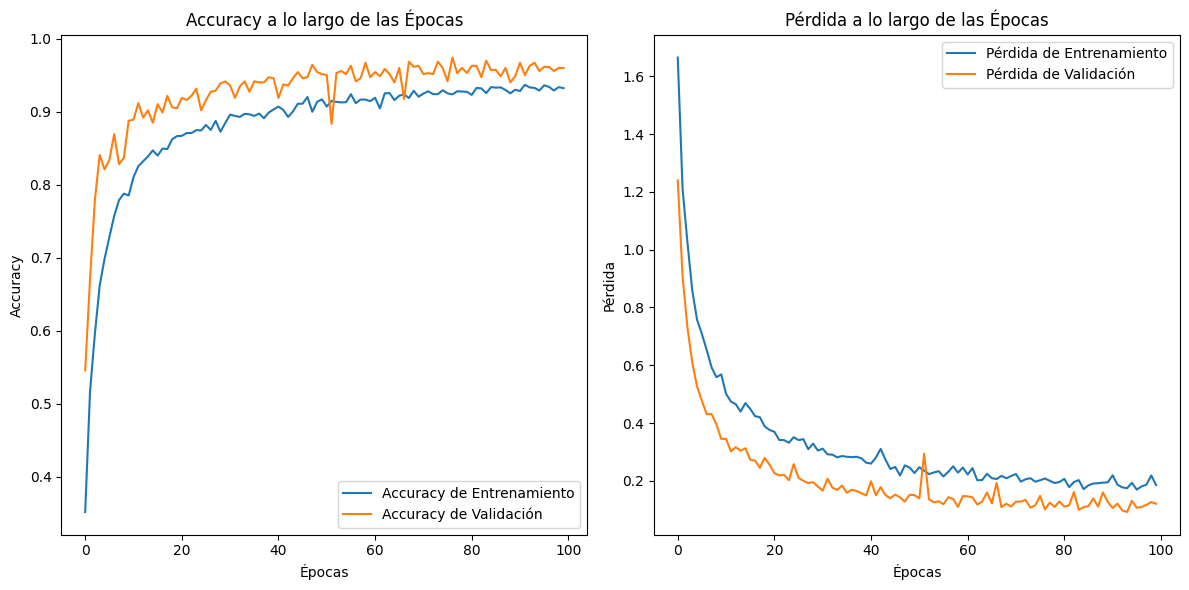

23/23 - 0s - loss: 0.1208 - accuracy: 0.9603 - 84ms/epoch - 4ms/step
Accuracy en el conjunto de prueba: 0.9603
23/23 [==============================] - 0s 3ms/step


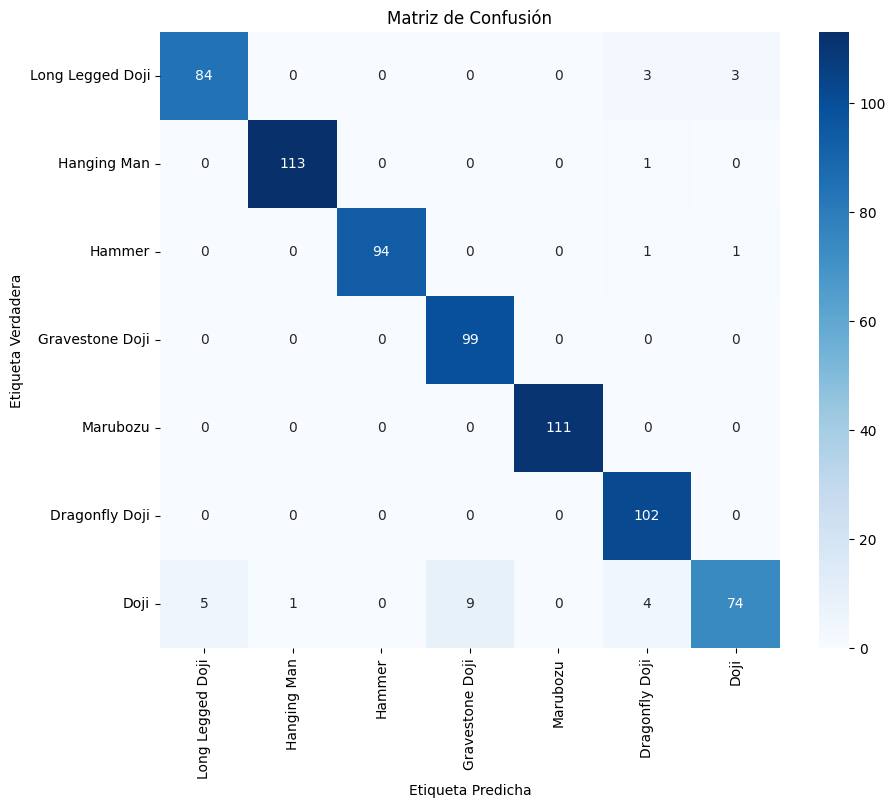

F1-score: 0.9593
Precision: 0.9612
Recall: 0.9603

Classification Report:
                   precision    recall  f1-score   support

Long Legged Doji       0.94      0.93      0.94        90
     Hanging Man       0.99      0.99      0.99       114
          Hammer       1.00      0.98      0.99        96
 Gravestone Doji       0.92      1.00      0.96        99
        Marubozu       1.00      1.00      1.00       111
  Dragonfly Doji       0.92      1.00      0.96       102
            Doji       0.95      0.80      0.87        93

        accuracy                           0.96       705
       macro avg       0.96      0.96      0.96       705
    weighted avg       0.96      0.96      0.96       705



In [ ]:
# Clasifica los patrones encontrados

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Cargar el dataset
data = pd.read_csv('binary_candle_dataset.csv')

# Filtrar solo las filas que tienen un patrón
data = data[data['Pattern Type'] != 'No Pattern']

# Redefinir las etiquetas para fusionar subcategorías en categorías más generales
def simplify_pattern(pattern):
    if 'Doji' in pattern:
        return 'Doji'
    return pattern

data.loc[:, 'General Pattern'] = data['Pattern Type'].apply(simplify_pattern)

# Codificar la columna "Trend" a 0 y 1
label_encoder = LabelEncoder()
data.loc[:, 'Trend'] = label_encoder.fit_transform(data['Trend'])

# Equilibrar las clases según la clase con el menor número de registros
classes = data['Pattern Type'].unique()
dfs = [data[data['Pattern Type'] == cls] for cls in classes]
min_size = min(len(d) for d in dfs)
dfs_resampled = [resample(d, replace=False, n_samples=min_size, random_state=42) for d in dfs]
data_balanced = pd.concat(dfs_resampled).sample(frac=1, random_state=42).reset_index(drop=True)

# Preparar los datos para el entrenamiento
data_balanced = data_balanced.dropna(subset=['RSI'])

X = data_balanced[['Range', 'Body Length', 'Upper Shadow', 'Lower Shadow', 'Trend']].values
y = data_balanced['Pattern Type'].values

# Convertir etiquetas de patrones a números
class_counts = data_balanced['Pattern Type'].value_counts()
pattern_to_num = {pattern: num for num, pattern in enumerate(class_counts.index)}
y_num = np.array([pattern_to_num[pattern] for pattern in y])

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_num, test_size=0.2, random_state=42)

# Convertir etiquetas a one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_counts))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_counts))

# Definir el modelo de red neuronal
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_counts), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Visualizar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy en el conjunto de prueba: {test_acc:.4f}')

# Predecir las etiquetas del conjunto de test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Crear un DataFrame con las predicciones y las etiquetas verdaderas
pred_df = pd.DataFrame({
    'True Label': y_test_labels,
    'Predicted Label': y_pred,
    'General Pattern': [simplify_pattern(class_counts.index[true_label]) for true_label in y_test_labels]
})

# Actualizar las etiquetas predichas
y_pred = pred_df['Predicted Label'].values

# Calcular la matriz de confusión y otras métricas
cm = confusion_matrix(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
classification_rep = classification_report(y_test_labels, y_pred, target_names=class_counts.index)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_counts.index, yticklabels=class_counts.index)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Imprimir métricas adicionales
print(f'F1-score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('\nClassification Report:\n', classification_rep)


# Paso 7: Muestra velas japonesas del dataset

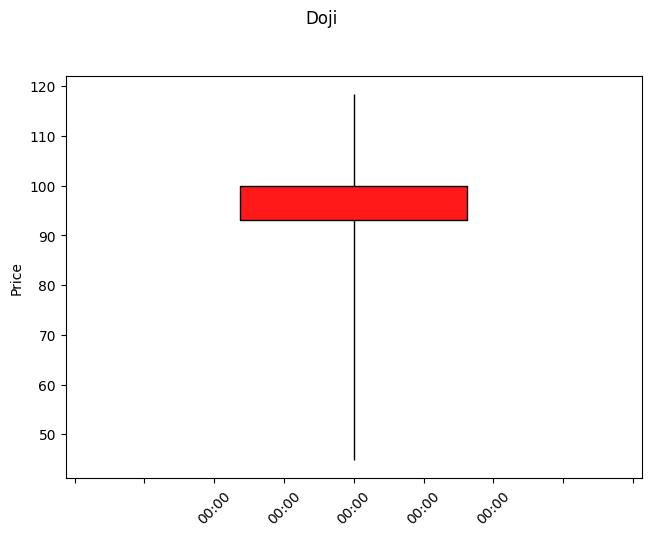

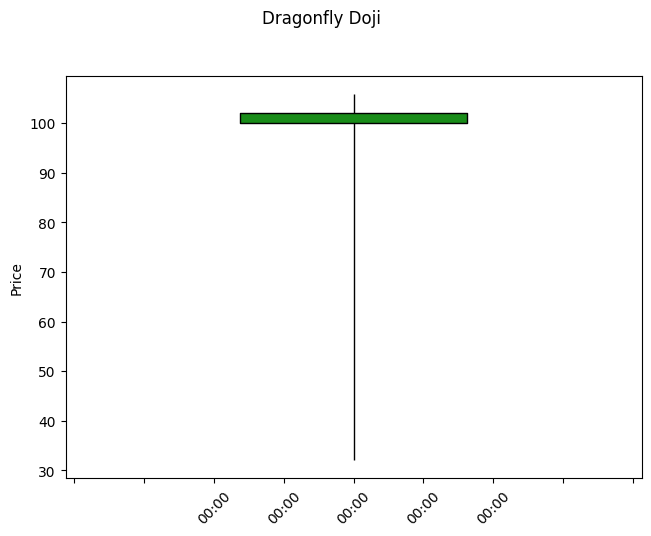

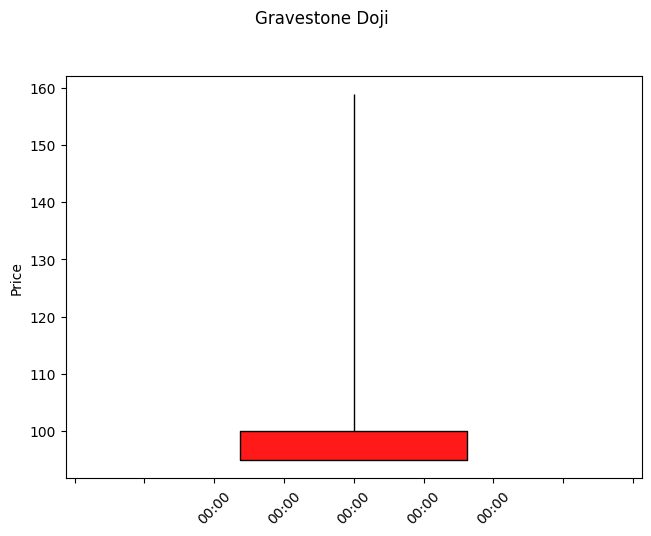

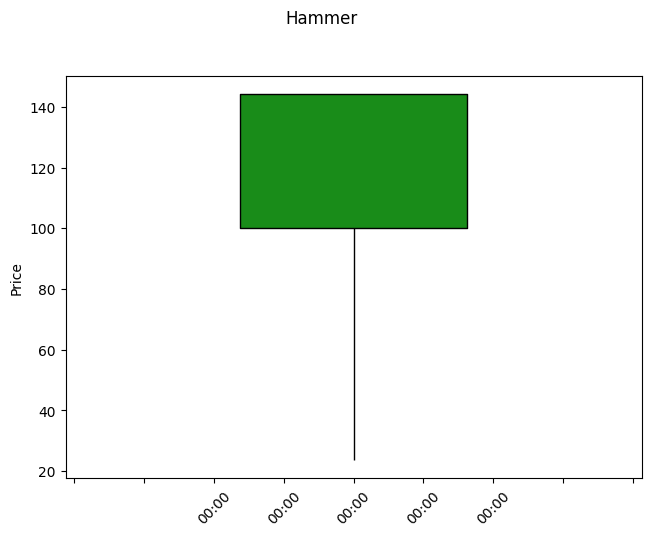

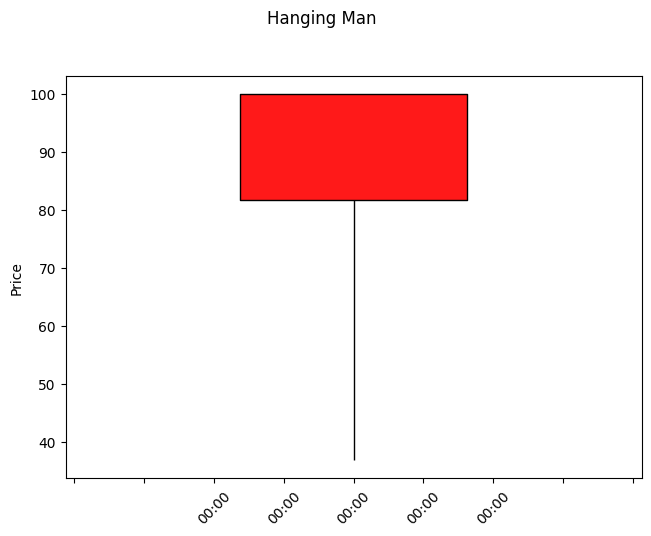

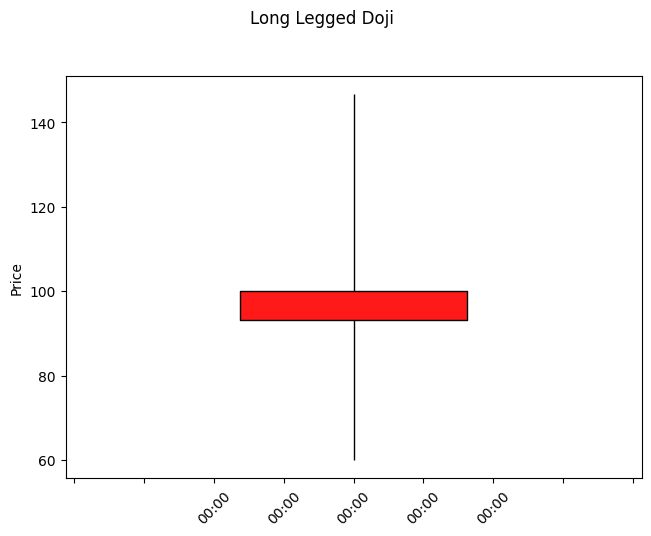

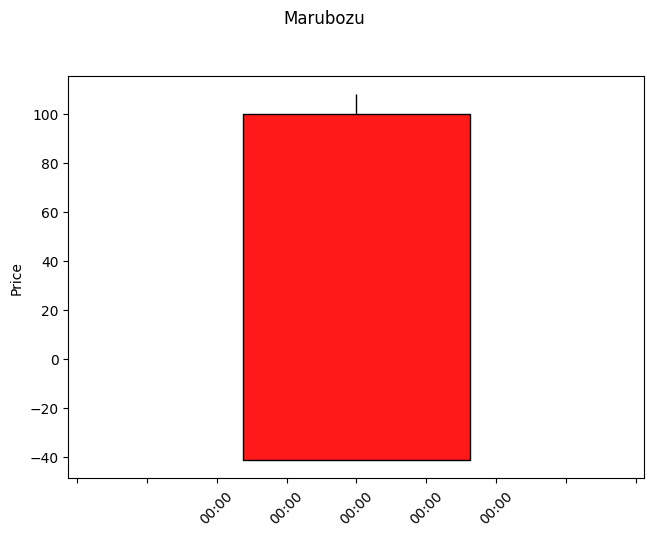

In [ ]:
import pandas as pd
import mplfinance as mpf

# Leer el dataset desde el archivo CSV
file_path = 'binary_candle_dataset.csv'
df = pd.read_csv(file_path)

# Crear una función para graficar las velas
def plot_candlestick(data, pattern_name):
    data['Date'] = pd.to_datetime(data.index)
    data.set_index('Date', inplace=True)
    mc = mpf.make_marketcolors(up='g', down='r', wick='black', edge='black')
    s = mpf.make_mpf_style(marketcolors=mc)
    mpf.plot(data, type='candle', style=s, title=pattern_name, ylabel='Price')

# Identificar las filas para cada patrón detectado
patterns = ['Doji', 'Dragonfly Doji', 'Gravestone Doji', 'Hammer', 'Hanging Man', 'Long Legged Doji', 'Marubozu']
pattern_rows = {}

for pattern in patterns:
    pattern_df = df[df['Pattern Type'] == pattern]
    if not pattern_df.empty:
        pattern_rows[pattern] = pattern_df.iloc[0]

# Crear un DataFrame para cada patrón y graficar
for pattern_name, row in pattern_rows.items():
    # Crear un DataFrame temporal con los datos de la vela
    temp_df = pd.DataFrame({
        'Open': [100],
        'High': [100 + row['High-Open']],
        'Low': [100 + row['Low-Open']],
        'Close': [100 + row['Close-Open']]
    })
    plot_candlestick(temp_df, pattern_name)


# Paso 8: Muestra gráficamente la estructura del clasificador binario

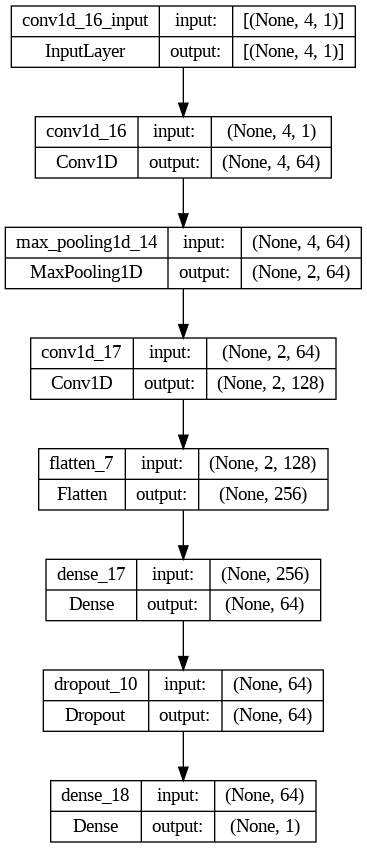

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Definir el modelo de red neuronal convolucional simplificado
input_shape = (4, 1)  # Ajusta este valor según la forma real de tus datos

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compilar el modelo (necesario para crear el diagrama)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Crear el diagrama de la red neuronal
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Paso 9: Muestra gráficamente la estructura del clasificador de patrones

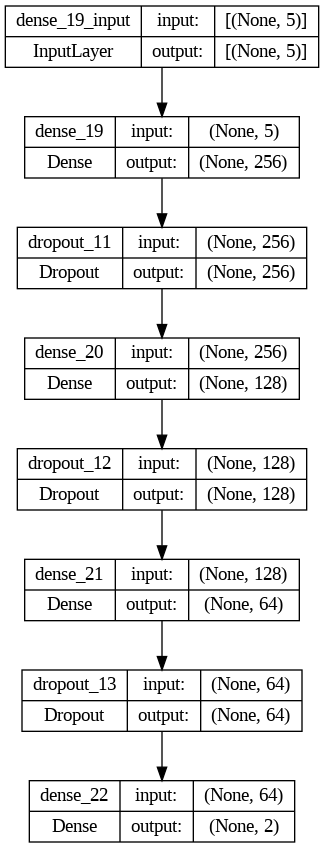

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Definir el modelo de red neuronal
input_shape = (5,)  # Ajusta este valor según la forma real de tus datos (en este caso, 5 características de entrada)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_counts), activation='softmax')
])

# Compilar el modelo (necesario para crear el diagrama)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Crear el diagrama de la red neuronal
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Si deseas ver la imagen generada dentro de un notebook Jupyter, puedes utilizar:
from IPython.display import Image
Image(filename='model_plot.png')